##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train and serve a TensorFlow model with TensorFlow Serving

**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access.  If you want to run it in a local Jupyter notebook, please proceed with caution.

Note: You can run this example right now in a Jupyter-style notebook, no setup required!  Just click "Run in Google Colab"

<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<tr><td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/serving/rest_simple">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
<td><a href="https://storage.googleapis.com/tensorflow_docs/tfx/docs/tutorials/serving/rest_simple.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td>
</tr></table></div>

This guide trains a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist), saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).  The focus is on TensorFlow Serving, rather than the modeling and training in TensorFlow, so for a complete example which focuses on the modeling and training see the [Basic Classification example](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_classification.ipynb).

This guide uses [tf.keras](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/keras.ipynb), a high-level API to build and train models in TensorFlow.

In [2]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [3]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx 1.9.1 requires grpcio<2,>=1.28.1, but you have grpcio 1.26.0 which is incompatible.
grpcio-status 1.47.0 requires grpcio>=1.47.0, but you have grpcio 1.26.0 which is incompatible.
google-cloud-pubsub 2.13.4 requires grpcio<2.0dev,>=1.38.1, but you have grpcio 1.26.0 which is incompatible.
google-cloud-bigquery 2.34.4 requires grpcio<2.0dev,>=1.38.1, but you have grpcio 1.26.0 which is incompatible.
apache-beam 2.40.0 requires grpcio<2,>=1.33.1, but you have grpcio 1.26.0 which is incompatible.


TensorFlow version: 2.9.1


## Create your model

### Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow, just import and load the data.

Note: Although these are really images, they are loaded as NumPy arrays and not binary image objects.

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

 8192/29515 [=======>......................] - ETA: 0s

29515/29515 [==============================] - 0s 0us/step


    8192/26421880 [..............................] - ETA: 0s

10133504/26421880 [==========>...................] - ETA: 0s

25559040/26421880 [============================>.] - ETA: 0s

26421880/26421880 [==============================] - 0s 0us/step


5148/5148 [==============================] - 0s 0us/step


   8192/4422102 [..............................] - ETA: 0s

4422102/4422102 [==============================] - 0s 0us/step



train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


### Train and evaluate your model

Let's use the simplest possible CNN, since we're not focused on the modeling part.

In [5]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 Conv1 (Conv2D)              (None, 13, 13, 8)         80        


 flatten (Flatten)           (None, 1352)              0         


 Dense (Dense)               (None, 10)                13530     


Total params: 13,610


Trainable params: 13,610


Non-trainable params: 0


_________________________________________________________________


Epoch 1/5


   1/1875 [..............................] - ETA: 2:17:03 - loss: 2.2983 - sparse_categorical_accuracy: 0.0625

  26/1875 [..............................] - ETA: 3s - loss: 2.0799 - sparse_categorical_accuracy: 0.3738     

  54/1875 [..............................] - ETA: 3s - loss: 1.7376 - sparse_categorical_accuracy: 0.4931

  82/1875 [>.............................] - ETA: 3s - loss: 1.4778 - sparse_categorical_accuracy: 0.5530

 110/1875 [>.............................] - ETA: 3s - loss: 1.2889 - sparse_categorical_accuracy: 0.6028

 137/1875 [=>............................] - ETA: 3s - loss: 1.1745 - sparse_categorical_accuracy: 0.6332

 165/1875 [=>............................] - ETA: 3s - loss: 1.0931 - sparse_categorical_accuracy: 0.6532

 193/1875 [==>...........................] - ETA: 3s - loss: 1.0278 - sparse_categorical_accuracy: 0.6715

 221/1875 [==>...........................] - ETA: 3s - loss: 0.9689 - sparse_categorical_accuracy: 0.6865

 248/1875 [==>...........................] - ETA: 3s - loss: 0.9295 - sparse_categorical_accuracy: 0.6963

 275/1875 [===>..........................] - ETA: 2s - loss: 0.8984 - sparse_categorical_accuracy: 0.7048

 302/1875 [===>..........................] - ETA: 2s - loss: 0.8679 - sparse_categorical_accuracy: 0.7129

 330/1875 [====>.........................] - ETA: 2s - loss: 0.8400 - sparse_categorical_accuracy: 0.7206

 358/1875 [====>.........................] - ETA: 2s - loss: 0.8172 - sparse_categorical_accuracy: 0.7272

 386/1875 [=====>........................] - ETA: 2s - loss: 0.7982 - sparse_categorical_accuracy: 0.7322

 414/1875 [=====>........................] - ETA: 2s - loss: 0.7830 - sparse_categorical_accuracy: 0.7375

 441/1875 [======>.......................] - ETA: 2s - loss: 0.7654 - sparse_categorical_accuracy: 0.7427

 468/1875 [======>.......................] - ETA: 2s - loss: 0.7526 - sparse_categorical_accuracy: 0.7471

 495/1875 [======>.......................] - ETA: 2s - loss: 0.7416 - sparse_categorical_accuracy: 0.7495

 523/1875 [=======>......................] - ETA: 2s - loss: 0.7275 - sparse_categorical_accuracy: 0.7536

 551/1875 [=======>......................] - ETA: 2s - loss: 0.7157 - sparse_categorical_accuracy: 0.7567

 579/1875 [========>.....................] - ETA: 2s - loss: 0.7048 - sparse_categorical_accuracy: 0.7598

 606/1875 [========>.....................] - ETA: 2s - loss: 0.6956 - sparse_categorical_accuracy: 0.7625

 634/1875 [=========>....................] - ETA: 2s - loss: 0.6885 - sparse_categorical_accuracy: 0.7648

 662/1875 [=========>....................] - ETA: 2s - loss: 0.6817 - sparse_categorical_accuracy: 0.7668

 690/1875 [==========>...................] - ETA: 2s - loss: 0.6737 - sparse_categorical_accuracy: 0.7693

 718/1875 [==========>...................] - ETA: 2s - loss: 0.6658 - sparse_categorical_accuracy: 0.7720

 745/1875 [==========>...................] - ETA: 2s - loss: 0.6610 - sparse_categorical_accuracy: 0.7737

 773/1875 [===========>..................] - ETA: 2s - loss: 0.6563 - sparse_categorical_accuracy: 0.7749

 801/1875 [===========>..................] - ETA: 1s - loss: 0.6505 - sparse_categorical_accuracy: 0.7769

 829/1875 [============>.................] - ETA: 1s - loss: 0.6458 - sparse_categorical_accuracy: 0.7786

 857/1875 [============>.................] - ETA: 1s - loss: 0.6406 - sparse_categorical_accuracy: 0.7805

 885/1875 [=============>................] - ETA: 1s - loss: 0.6349 - sparse_categorical_accuracy: 0.7821

 914/1875 [=============>................] - ETA: 1s - loss: 0.6299 - sparse_categorical_accuracy: 0.7840

 941/1875 [==============>...............] - ETA: 1s - loss: 0.6263 - sparse_categorical_accuracy: 0.7849

 968/1875 [==============>...............] - ETA: 1s - loss: 0.6219 - sparse_categorical_accuracy: 0.7865

 995/1875 [==============>...............] - ETA: 1s - loss: 0.6176 - sparse_categorical_accuracy: 0.7880

1022/1875 [===============>..............] - ETA: 1s - loss: 0.6135 - sparse_categorical_accuracy: 0.7892

1049/1875 [===============>..............] - ETA: 1s - loss: 0.6104 - sparse_categorical_accuracy: 0.7900

1075/1875 [================>.............] - ETA: 1s - loss: 0.6063 - sparse_categorical_accuracy: 0.7915

1102/1875 [================>.............] - ETA: 1s - loss: 0.6026 - sparse_categorical_accuracy: 0.7926

1129/1875 [=================>............] - ETA: 1s - loss: 0.6003 - sparse_categorical_accuracy: 0.7933

1156/1875 [=================>............] - ETA: 1s - loss: 0.5986 - sparse_categorical_accuracy: 0.7939

1183/1875 [=================>............] - ETA: 1s - loss: 0.5950 - sparse_categorical_accuracy: 0.7951

1210/1875 [==================>...........] - ETA: 1s - loss: 0.5911 - sparse_categorical_accuracy: 0.7965

1237/1875 [==================>...........] - ETA: 1s - loss: 0.5876 - sparse_categorical_accuracy: 0.7977

1265/1875 [===================>..........] - ETA: 1s - loss: 0.5834 - sparse_categorical_accuracy: 0.7990

1293/1875 [===================>..........] - ETA: 1s - loss: 0.5804 - sparse_categorical_accuracy: 0.8003

1322/1875 [====================>.........] - ETA: 1s - loss: 0.5776 - sparse_categorical_accuracy: 0.8012

1350/1875 [====================>.........] - ETA: 0s - loss: 0.5742 - sparse_categorical_accuracy: 0.8026

1378/1875 [=====================>........] - ETA: 0s - loss: 0.5716 - sparse_categorical_accuracy: 0.8031

1405/1875 [=====================>........] - ETA: 0s - loss: 0.5695 - sparse_categorical_accuracy: 0.8036

1432/1875 [=====================>........] - ETA: 0s - loss: 0.5662 - sparse_categorical_accuracy: 0.8046

1460/1875 [======================>.......] - ETA: 0s - loss: 0.5629 - sparse_categorical_accuracy: 0.8055

1487/1875 [======================>.......] - ETA: 0s - loss: 0.5600 - sparse_categorical_accuracy: 0.8066

1514/1875 [=======================>......] - ETA: 0s - loss: 0.5580 - sparse_categorical_accuracy: 0.8073

1542/1875 [=======================>......] - ETA: 0s - loss: 0.5576 - sparse_categorical_accuracy: 0.8074

1570/1875 [========================>.....] - ETA: 0s - loss: 0.5550 - sparse_categorical_accuracy: 0.8084

1598/1875 [========================>.....] - ETA: 0s - loss: 0.5519 - sparse_categorical_accuracy: 0.8094

1625/1875 [=========================>....] - ETA: 0s - loss: 0.5493 - sparse_categorical_accuracy: 0.8105

1653/1875 [=========================>....] - ETA: 0s - loss: 0.5472 - sparse_categorical_accuracy: 0.8111

1680/1875 [=========================>....] - ETA: 0s - loss: 0.5443 - sparse_categorical_accuracy: 0.8120

1707/1875 [==========================>...] - ETA: 0s - loss: 0.5430 - sparse_categorical_accuracy: 0.8124

1734/1875 [==========================>...] - ETA: 0s - loss: 0.5417 - sparse_categorical_accuracy: 0.8127

1761/1875 [===========================>..] - ETA: 0s - loss: 0.5400 - sparse_categorical_accuracy: 0.8135

1788/1875 [===========================>..] - ETA: 0s - loss: 0.5382 - sparse_categorical_accuracy: 0.8140

1815/1875 [============================>.] - ETA: 0s - loss: 0.5365 - sparse_categorical_accuracy: 0.8146

1842/1875 [============================>.] - ETA: 0s - loss: 0.5342 - sparse_categorical_accuracy: 0.8155

1869/1875 [============================>.] - ETA: 0s - loss: 0.5324 - sparse_categorical_accuracy: 0.8160

1875/1875 [==============================] - 8s 2ms/step - loss: 0.5322 - sparse_categorical_accuracy: 0.8161


Epoch 2/5


   1/1875 [..............................] - ETA: 4s - loss: 0.3705 - sparse_categorical_accuracy: 0.9062

  28/1875 [..............................] - ETA: 3s - loss: 0.4234 - sparse_categorical_accuracy: 0.8348

  55/1875 [..............................] - ETA: 3s - loss: 0.3940 - sparse_categorical_accuracy: 0.8545

  82/1875 [>.............................] - ETA: 3s - loss: 0.3983 - sparse_categorical_accuracy: 0.8540

 109/1875 [>.............................] - ETA: 3s - loss: 0.4117 - sparse_categorical_accuracy: 0.8501

 136/1875 [=>............................] - ETA: 3s - loss: 0.4116 - sparse_categorical_accuracy: 0.8518

 163/1875 [=>............................] - ETA: 3s - loss: 0.4138 - sparse_categorical_accuracy: 0.8514

 190/1875 [==>...........................] - ETA: 3s - loss: 0.4159 - sparse_categorical_accuracy: 0.8490

 217/1875 [==>...........................] - ETA: 3s - loss: 0.4174 - sparse_categorical_accuracy: 0.8495

 244/1875 [==>...........................] - ETA: 3s - loss: 0.4126 - sparse_categorical_accuracy: 0.8530

 271/1875 [===>..........................] - ETA: 3s - loss: 0.4112 - sparse_categorical_accuracy: 0.8544

 298/1875 [===>..........................] - ETA: 2s - loss: 0.4137 - sparse_categorical_accuracy: 0.8534

 325/1875 [====>.........................] - ETA: 2s - loss: 0.4099 - sparse_categorical_accuracy: 0.8548

 352/1875 [====>.........................] - ETA: 2s - loss: 0.4103 - sparse_categorical_accuracy: 0.8556

 379/1875 [=====>........................] - ETA: 2s - loss: 0.4086 - sparse_categorical_accuracy: 0.8559

 406/1875 [=====>........................] - ETA: 2s - loss: 0.4062 - sparse_categorical_accuracy: 0.8568

 434/1875 [=====>........................] - ETA: 2s - loss: 0.4061 - sparse_categorical_accuracy: 0.8566

 461/1875 [======>.......................] - ETA: 2s - loss: 0.4041 - sparse_categorical_accuracy: 0.8573

 488/1875 [======>.......................] - ETA: 2s - loss: 0.4052 - sparse_categorical_accuracy: 0.8571

 515/1875 [=======>......................] - ETA: 2s - loss: 0.4047 - sparse_categorical_accuracy: 0.8567

 542/1875 [=======>......................] - ETA: 2s - loss: 0.4047 - sparse_categorical_accuracy: 0.8570

 569/1875 [========>.....................] - ETA: 2s - loss: 0.4011 - sparse_categorical_accuracy: 0.8583

 597/1875 [========>.....................] - ETA: 2s - loss: 0.4014 - sparse_categorical_accuracy: 0.8581

 624/1875 [========>.....................] - ETA: 2s - loss: 0.3988 - sparse_categorical_accuracy: 0.8592

 652/1875 [=========>....................] - ETA: 2s - loss: 0.3975 - sparse_categorical_accuracy: 0.8594

 680/1875 [=========>....................] - ETA: 2s - loss: 0.3982 - sparse_categorical_accuracy: 0.8591

 708/1875 [==========>...................] - ETA: 2s - loss: 0.3993 - sparse_categorical_accuracy: 0.8588

 735/1875 [==========>...................] - ETA: 2s - loss: 0.3987 - sparse_categorical_accuracy: 0.8589

 763/1875 [===========>..................] - ETA: 2s - loss: 0.3970 - sparse_categorical_accuracy: 0.8595

 791/1875 [===========>..................] - ETA: 2s - loss: 0.3976 - sparse_categorical_accuracy: 0.8593

 818/1875 [============>.................] - ETA: 1s - loss: 0.3978 - sparse_categorical_accuracy: 0.8595

 845/1875 [============>.................] - ETA: 1s - loss: 0.3981 - sparse_categorical_accuracy: 0.8595

 872/1875 [============>.................] - ETA: 1s - loss: 0.3971 - sparse_categorical_accuracy: 0.8598

 899/1875 [=============>................] - ETA: 1s - loss: 0.3956 - sparse_categorical_accuracy: 0.8602

 927/1875 [=============>................] - ETA: 1s - loss: 0.3945 - sparse_categorical_accuracy: 0.8602

 954/1875 [==============>...............] - ETA: 1s - loss: 0.3928 - sparse_categorical_accuracy: 0.8608

 981/1875 [==============>...............] - ETA: 1s - loss: 0.3931 - sparse_categorical_accuracy: 0.8606

1009/1875 [===============>..............] - ETA: 1s - loss: 0.3928 - sparse_categorical_accuracy: 0.8609

1037/1875 [===============>..............] - ETA: 1s - loss: 0.3931 - sparse_categorical_accuracy: 0.8610

1065/1875 [================>.............] - ETA: 1s - loss: 0.3927 - sparse_categorical_accuracy: 0.8610

1092/1875 [================>.............] - ETA: 1s - loss: 0.3921 - sparse_categorical_accuracy: 0.8611

1120/1875 [================>.............] - ETA: 1s - loss: 0.3912 - sparse_categorical_accuracy: 0.8614

1148/1875 [=================>............] - ETA: 1s - loss: 0.3902 - sparse_categorical_accuracy: 0.8619

1176/1875 [=================>............] - ETA: 1s - loss: 0.3892 - sparse_categorical_accuracy: 0.8625

1204/1875 [==================>...........] - ETA: 1s - loss: 0.3877 - sparse_categorical_accuracy: 0.8630

1232/1875 [==================>...........] - ETA: 1s - loss: 0.3871 - sparse_categorical_accuracy: 0.8631

1260/1875 [===================>..........] - ETA: 1s - loss: 0.3869 - sparse_categorical_accuracy: 0.8631

1288/1875 [===================>..........] - ETA: 1s - loss: 0.3860 - sparse_categorical_accuracy: 0.8635

1316/1875 [====================>.........] - ETA: 1s - loss: 0.3858 - sparse_categorical_accuracy: 0.8636

1344/1875 [====================>.........] - ETA: 0s - loss: 0.3841 - sparse_categorical_accuracy: 0.8643

1372/1875 [====================>.........] - ETA: 0s - loss: 0.3837 - sparse_categorical_accuracy: 0.8645

1398/1875 [=====================>........] - ETA: 0s - loss: 0.3829 - sparse_categorical_accuracy: 0.8646

1425/1875 [=====================>........] - ETA: 0s - loss: 0.3824 - sparse_categorical_accuracy: 0.8650

1451/1875 [======================>.......] - ETA: 0s - loss: 0.3815 - sparse_categorical_accuracy: 0.8653

1476/1875 [======================>.......] - ETA: 0s - loss: 0.3809 - sparse_categorical_accuracy: 0.8655

1501/1875 [=======================>......] - ETA: 0s - loss: 0.3803 - sparse_categorical_accuracy: 0.8660

1527/1875 [=======================>......] - ETA: 0s - loss: 0.3797 - sparse_categorical_accuracy: 0.8661

1552/1875 [=======================>......] - ETA: 0s - loss: 0.3799 - sparse_categorical_accuracy: 0.8663

1578/1875 [========================>.....] - ETA: 0s - loss: 0.3796 - sparse_categorical_accuracy: 0.8663

1604/1875 [========================>.....] - ETA: 0s - loss: 0.3794 - sparse_categorical_accuracy: 0.8663

1629/1875 [=========================>....] - ETA: 0s - loss: 0.3792 - sparse_categorical_accuracy: 0.8663

1656/1875 [=========================>....] - ETA: 0s - loss: 0.3782 - sparse_categorical_accuracy: 0.8667

1683/1875 [=========================>....] - ETA: 0s - loss: 0.3782 - sparse_categorical_accuracy: 0.8668

1709/1875 [==========================>...] - ETA: 0s - loss: 0.3784 - sparse_categorical_accuracy: 0.8668

1736/1875 [==========================>...] - ETA: 0s - loss: 0.3784 - sparse_categorical_accuracy: 0.8665

1763/1875 [===========================>..] - ETA: 0s - loss: 0.3784 - sparse_categorical_accuracy: 0.8663

1790/1875 [===========================>..] - ETA: 0s - loss: 0.3782 - sparse_categorical_accuracy: 0.8665

1817/1875 [============================>.] - ETA: 0s - loss: 0.3780 - sparse_categorical_accuracy: 0.8666

1845/1875 [============================>.] - ETA: 0s - loss: 0.3778 - sparse_categorical_accuracy: 0.8667

1872/1875 [============================>.] - ETA: 0s - loss: 0.3776 - sparse_categorical_accuracy: 0.8666

1875/1875 [==============================] - 4s 2ms/step - loss: 0.3776 - sparse_categorical_accuracy: 0.8666


Epoch 3/5


   1/1875 [..............................] - ETA: 4s - loss: 0.3704 - sparse_categorical_accuracy: 0.8750

  28/1875 [..............................] - ETA: 3s - loss: 0.3579 - sparse_categorical_accuracy: 0.8761

  54/1875 [..............................] - ETA: 3s - loss: 0.3326 - sparse_categorical_accuracy: 0.8831

  80/1875 [>.............................] - ETA: 3s - loss: 0.3327 - sparse_categorical_accuracy: 0.8824

 106/1875 [>.............................] - ETA: 3s - loss: 0.3376 - sparse_categorical_accuracy: 0.8806

 133/1875 [=>............................] - ETA: 3s - loss: 0.3439 - sparse_categorical_accuracy: 0.8778

 160/1875 [=>............................] - ETA: 3s - loss: 0.3418 - sparse_categorical_accuracy: 0.8773

 187/1875 [=>............................] - ETA: 3s - loss: 0.3460 - sparse_categorical_accuracy: 0.8765

 214/1875 [==>...........................] - ETA: 3s - loss: 0.3479 - sparse_categorical_accuracy: 0.8760

 242/1875 [==>...........................] - ETA: 3s - loss: 0.3470 - sparse_categorical_accuracy: 0.8758

 269/1875 [===>..........................] - ETA: 3s - loss: 0.3469 - sparse_categorical_accuracy: 0.8765

 296/1875 [===>..........................] - ETA: 3s - loss: 0.3464 - sparse_categorical_accuracy: 0.8787

 323/1875 [====>.........................] - ETA: 2s - loss: 0.3459 - sparse_categorical_accuracy: 0.8788

 349/1875 [====>.........................] - ETA: 2s - loss: 0.3467 - sparse_categorical_accuracy: 0.8782

 375/1875 [=====>........................] - ETA: 2s - loss: 0.3466 - sparse_categorical_accuracy: 0.8775

 401/1875 [=====>........................] - ETA: 2s - loss: 0.3469 - sparse_categorical_accuracy: 0.8775

 427/1875 [=====>........................] - ETA: 2s - loss: 0.3476 - sparse_categorical_accuracy: 0.8772

 453/1875 [======>.......................] - ETA: 2s - loss: 0.3482 - sparse_categorical_accuracy: 0.8778

 479/1875 [======>.......................] - ETA: 2s - loss: 0.3457 - sparse_categorical_accuracy: 0.8790

 506/1875 [=======>......................] - ETA: 2s - loss: 0.3445 - sparse_categorical_accuracy: 0.8794

 533/1875 [=======>......................] - ETA: 2s - loss: 0.3438 - sparse_categorical_accuracy: 0.8796

 560/1875 [=======>......................] - ETA: 2s - loss: 0.3436 - sparse_categorical_accuracy: 0.8797

 587/1875 [========>.....................] - ETA: 2s - loss: 0.3454 - sparse_categorical_accuracy: 0.8790

 614/1875 [========>.....................] - ETA: 2s - loss: 0.3446 - sparse_categorical_accuracy: 0.8793

 640/1875 [=========>....................] - ETA: 2s - loss: 0.3454 - sparse_categorical_accuracy: 0.8791

 665/1875 [=========>....................] - ETA: 2s - loss: 0.3467 - sparse_categorical_accuracy: 0.8787

 691/1875 [==========>...................] - ETA: 2s - loss: 0.3448 - sparse_categorical_accuracy: 0.8793

 716/1875 [==========>...................] - ETA: 2s - loss: 0.3446 - sparse_categorical_accuracy: 0.8790

 741/1875 [==========>...................] - ETA: 2s - loss: 0.3438 - sparse_categorical_accuracy: 0.8792

 767/1875 [===========>..................] - ETA: 2s - loss: 0.3428 - sparse_categorical_accuracy: 0.8797

 793/1875 [===========>..................] - ETA: 2s - loss: 0.3414 - sparse_categorical_accuracy: 0.8802

 821/1875 [============>.................] - ETA: 2s - loss: 0.3401 - sparse_categorical_accuracy: 0.8807

 847/1875 [============>.................] - ETA: 1s - loss: 0.3406 - sparse_categorical_accuracy: 0.8803

 874/1875 [============>.................] - ETA: 1s - loss: 0.3404 - sparse_categorical_accuracy: 0.8801

 901/1875 [=============>................] - ETA: 1s - loss: 0.3408 - sparse_categorical_accuracy: 0.8798

 928/1875 [=============>................] - ETA: 1s - loss: 0.3412 - sparse_categorical_accuracy: 0.8796

 955/1875 [==============>...............] - ETA: 1s - loss: 0.3423 - sparse_categorical_accuracy: 0.8790

 981/1875 [==============>...............] - ETA: 1s - loss: 0.3429 - sparse_categorical_accuracy: 0.8790

1008/1875 [===============>..............] - ETA: 1s - loss: 0.3430 - sparse_categorical_accuracy: 0.8788

1035/1875 [===============>..............] - ETA: 1s - loss: 0.3421 - sparse_categorical_accuracy: 0.8790

1062/1875 [===============>..............] - ETA: 1s - loss: 0.3422 - sparse_categorical_accuracy: 0.8788

1087/1875 [================>.............] - ETA: 1s - loss: 0.3421 - sparse_categorical_accuracy: 0.8788

1112/1875 [================>.............] - ETA: 1s - loss: 0.3424 - sparse_categorical_accuracy: 0.8785

1138/1875 [=================>............] - ETA: 1s - loss: 0.3427 - sparse_categorical_accuracy: 0.8783

1164/1875 [=================>............] - ETA: 1s - loss: 0.3428 - sparse_categorical_accuracy: 0.8783

1189/1875 [==================>...........] - ETA: 1s - loss: 0.3430 - sparse_categorical_accuracy: 0.8782

1215/1875 [==================>...........] - ETA: 1s - loss: 0.3423 - sparse_categorical_accuracy: 0.8783

1241/1875 [==================>...........] - ETA: 1s - loss: 0.3422 - sparse_categorical_accuracy: 0.8782

1267/1875 [===================>..........] - ETA: 1s - loss: 0.3418 - sparse_categorical_accuracy: 0.8786

1294/1875 [===================>..........] - ETA: 1s - loss: 0.3419 - sparse_categorical_accuracy: 0.8786

1320/1875 [====================>.........] - ETA: 1s - loss: 0.3410 - sparse_categorical_accuracy: 0.8789

1347/1875 [====================>.........] - ETA: 1s - loss: 0.3410 - sparse_categorical_accuracy: 0.8789

1374/1875 [====================>.........] - ETA: 0s - loss: 0.3419 - sparse_categorical_accuracy: 0.8784

1401/1875 [=====================>........] - ETA: 0s - loss: 0.3419 - sparse_categorical_accuracy: 0.8785

1427/1875 [=====================>........] - ETA: 0s - loss: 0.3417 - sparse_categorical_accuracy: 0.8786

1454/1875 [======================>.......] - ETA: 0s - loss: 0.3417 - sparse_categorical_accuracy: 0.8787

1480/1875 [======================>.......] - ETA: 0s - loss: 0.3423 - sparse_categorical_accuracy: 0.8786

1506/1875 [=======================>......] - ETA: 0s - loss: 0.3432 - sparse_categorical_accuracy: 0.8782

1533/1875 [=======================>......] - ETA: 0s - loss: 0.3433 - sparse_categorical_accuracy: 0.8783

1560/1875 [=======================>......] - ETA: 0s - loss: 0.3433 - sparse_categorical_accuracy: 0.8782

1588/1875 [========================>.....] - ETA: 0s - loss: 0.3431 - sparse_categorical_accuracy: 0.8782

1615/1875 [========================>.....] - ETA: 0s - loss: 0.3425 - sparse_categorical_accuracy: 0.8783

1643/1875 [=========================>....] - ETA: 0s - loss: 0.3424 - sparse_categorical_accuracy: 0.8784

1670/1875 [=========================>....] - ETA: 0s - loss: 0.3423 - sparse_categorical_accuracy: 0.8785

1697/1875 [==========================>...] - ETA: 0s - loss: 0.3418 - sparse_categorical_accuracy: 0.8787

1723/1875 [==========================>...] - ETA: 0s - loss: 0.3417 - sparse_categorical_accuracy: 0.8788

1749/1875 [==========================>...] - ETA: 0s - loss: 0.3414 - sparse_categorical_accuracy: 0.8789

1776/1875 [===========================>..] - ETA: 0s - loss: 0.3415 - sparse_categorical_accuracy: 0.8791

1802/1875 [===========================>..] - ETA: 0s - loss: 0.3409 - sparse_categorical_accuracy: 0.8791

1828/1875 [============================>.] - ETA: 0s - loss: 0.3412 - sparse_categorical_accuracy: 0.8790

1854/1875 [============================>.] - ETA: 0s - loss: 0.3412 - sparse_categorical_accuracy: 0.8791

1875/1875 [==============================] - 4s 2ms/step - loss: 0.3416 - sparse_categorical_accuracy: 0.8790


Epoch 4/5


   1/1875 [..............................] - ETA: 4s - loss: 0.2931 - sparse_categorical_accuracy: 0.8750

  27/1875 [..............................] - ETA: 3s - loss: 0.2962 - sparse_categorical_accuracy: 0.8889

  53/1875 [..............................] - ETA: 3s - loss: 0.3006 - sparse_categorical_accuracy: 0.8915

  78/1875 [>.............................] - ETA: 3s - loss: 0.2974 - sparse_categorical_accuracy: 0.8938

 104/1875 [>.............................] - ETA: 3s - loss: 0.2981 - sparse_categorical_accuracy: 0.8939

 130/1875 [=>............................] - ETA: 3s - loss: 0.3019 - sparse_categorical_accuracy: 0.8957

 156/1875 [=>............................] - ETA: 3s - loss: 0.3118 - sparse_categorical_accuracy: 0.8898

 182/1875 [=>............................] - ETA: 3s - loss: 0.3156 - sparse_categorical_accuracy: 0.8880

 208/1875 [==>...........................] - ETA: 3s - loss: 0.3107 - sparse_categorical_accuracy: 0.8896

 234/1875 [==>...........................] - ETA: 3s - loss: 0.3126 - sparse_categorical_accuracy: 0.8882

 259/1875 [===>..........................] - ETA: 3s - loss: 0.3177 - sparse_categorical_accuracy: 0.8863

 285/1875 [===>..........................] - ETA: 3s - loss: 0.3182 - sparse_categorical_accuracy: 0.8859

 311/1875 [===>..........................] - ETA: 3s - loss: 0.3237 - sparse_categorical_accuracy: 0.8825

 337/1875 [====>.........................] - ETA: 3s - loss: 0.3200 - sparse_categorical_accuracy: 0.8849

 363/1875 [====>.........................] - ETA: 2s - loss: 0.3194 - sparse_categorical_accuracy: 0.8856

 389/1875 [=====>........................] - ETA: 2s - loss: 0.3218 - sparse_categorical_accuracy: 0.8852

 415/1875 [=====>........................] - ETA: 2s - loss: 0.3211 - sparse_categorical_accuracy: 0.8854

 441/1875 [======>.......................] - ETA: 2s - loss: 0.3231 - sparse_categorical_accuracy: 0.8856

 467/1875 [======>.......................] - ETA: 2s - loss: 0.3215 - sparse_categorical_accuracy: 0.8866

 493/1875 [======>.......................] - ETA: 2s - loss: 0.3217 - sparse_categorical_accuracy: 0.8869

 519/1875 [=======>......................] - ETA: 2s - loss: 0.3214 - sparse_categorical_accuracy: 0.8874

 544/1875 [=======>......................] - ETA: 2s - loss: 0.3225 - sparse_categorical_accuracy: 0.8873

 569/1875 [========>.....................] - ETA: 2s - loss: 0.3211 - sparse_categorical_accuracy: 0.8881

 595/1875 [========>.....................] - ETA: 2s - loss: 0.3227 - sparse_categorical_accuracy: 0.8879

 621/1875 [========>.....................] - ETA: 2s - loss: 0.3221 - sparse_categorical_accuracy: 0.8879

 647/1875 [=========>....................] - ETA: 2s - loss: 0.3222 - sparse_categorical_accuracy: 0.8880

 672/1875 [=========>....................] - ETA: 2s - loss: 0.3219 - sparse_categorical_accuracy: 0.8885

 698/1875 [==========>...................] - ETA: 2s - loss: 0.3212 - sparse_categorical_accuracy: 0.8888

 724/1875 [==========>...................] - ETA: 2s - loss: 0.3204 - sparse_categorical_accuracy: 0.8886

 750/1875 [===========>..................] - ETA: 2s - loss: 0.3213 - sparse_categorical_accuracy: 0.8887

 776/1875 [===========>..................] - ETA: 2s - loss: 0.3208 - sparse_categorical_accuracy: 0.8887

 802/1875 [===========>..................] - ETA: 2s - loss: 0.3194 - sparse_categorical_accuracy: 0.8892

 828/1875 [============>.................] - ETA: 2s - loss: 0.3201 - sparse_categorical_accuracy: 0.8887

 854/1875 [============>.................] - ETA: 2s - loss: 0.3203 - sparse_categorical_accuracy: 0.8882

 881/1875 [=============>................] - ETA: 1s - loss: 0.3197 - sparse_categorical_accuracy: 0.8884

 908/1875 [=============>................] - ETA: 1s - loss: 0.3208 - sparse_categorical_accuracy: 0.8881

 935/1875 [=============>................] - ETA: 1s - loss: 0.3216 - sparse_categorical_accuracy: 0.8880

 962/1875 [==============>...............] - ETA: 1s - loss: 0.3226 - sparse_categorical_accuracy: 0.8877

 988/1875 [==============>...............] - ETA: 1s - loss: 0.3233 - sparse_categorical_accuracy: 0.8874

1014/1875 [===============>..............] - ETA: 1s - loss: 0.3233 - sparse_categorical_accuracy: 0.8870

1041/1875 [===============>..............] - ETA: 1s - loss: 0.3238 - sparse_categorical_accuracy: 0.8865

1067/1875 [================>.............] - ETA: 1s - loss: 0.3253 - sparse_categorical_accuracy: 0.8857

1093/1875 [================>.............] - ETA: 1s - loss: 0.3247 - sparse_categorical_accuracy: 0.8857

1120/1875 [================>.............] - ETA: 1s - loss: 0.3253 - sparse_categorical_accuracy: 0.8852

1147/1875 [=================>............] - ETA: 1s - loss: 0.3250 - sparse_categorical_accuracy: 0.8853

1175/1875 [=================>............] - ETA: 1s - loss: 0.3261 - sparse_categorical_accuracy: 0.8850

1202/1875 [==================>...........] - ETA: 1s - loss: 0.3259 - sparse_categorical_accuracy: 0.8852

1230/1875 [==================>...........] - ETA: 1s - loss: 0.3249 - sparse_categorical_accuracy: 0.8853

1257/1875 [===================>..........] - ETA: 1s - loss: 0.3251 - sparse_categorical_accuracy: 0.8853

1284/1875 [===================>..........] - ETA: 1s - loss: 0.3253 - sparse_categorical_accuracy: 0.8851

1311/1875 [===================>..........] - ETA: 1s - loss: 0.3248 - sparse_categorical_accuracy: 0.8852

1338/1875 [====================>.........] - ETA: 1s - loss: 0.3242 - sparse_categorical_accuracy: 0.8853

1366/1875 [====================>.........] - ETA: 0s - loss: 0.3242 - sparse_categorical_accuracy: 0.8854

1393/1875 [=====================>........] - ETA: 0s - loss: 0.3240 - sparse_categorical_accuracy: 0.8856

1421/1875 [=====================>........] - ETA: 0s - loss: 0.3234 - sparse_categorical_accuracy: 0.8856

1448/1875 [======================>.......] - ETA: 0s - loss: 0.3231 - sparse_categorical_accuracy: 0.8855

1475/1875 [======================>.......] - ETA: 0s - loss: 0.3236 - sparse_categorical_accuracy: 0.8851

1502/1875 [=======================>......] - ETA: 0s - loss: 0.3248 - sparse_categorical_accuracy: 0.8849

1527/1875 [=======================>......] - ETA: 0s - loss: 0.3246 - sparse_categorical_accuracy: 0.8849

1553/1875 [=======================>......] - ETA: 0s - loss: 0.3239 - sparse_categorical_accuracy: 0.8852

1580/1875 [========================>.....] - ETA: 0s - loss: 0.3235 - sparse_categorical_accuracy: 0.8852

1606/1875 [========================>.....] - ETA: 0s - loss: 0.3237 - sparse_categorical_accuracy: 0.8852

1632/1875 [=========================>....] - ETA: 0s - loss: 0.3244 - sparse_categorical_accuracy: 0.8848

1658/1875 [=========================>....] - ETA: 0s - loss: 0.3243 - sparse_categorical_accuracy: 0.8849

1685/1875 [=========================>....] - ETA: 0s - loss: 0.3240 - sparse_categorical_accuracy: 0.8847

1712/1875 [==========================>...] - ETA: 0s - loss: 0.3241 - sparse_categorical_accuracy: 0.8845

1740/1875 [==========================>...] - ETA: 0s - loss: 0.3242 - sparse_categorical_accuracy: 0.8845

1767/1875 [===========================>..] - ETA: 0s - loss: 0.3237 - sparse_categorical_accuracy: 0.8848

1793/1875 [===========================>..] - ETA: 0s - loss: 0.3234 - sparse_categorical_accuracy: 0.8849

1820/1875 [============================>.] - ETA: 0s - loss: 0.3233 - sparse_categorical_accuracy: 0.8848

1847/1875 [============================>.] - ETA: 0s - loss: 0.3231 - sparse_categorical_accuracy: 0.8848

1874/1875 [============================>.] - ETA: 0s - loss: 0.3224 - sparse_categorical_accuracy: 0.8850

1875/1875 [==============================] - 4s 2ms/step - loss: 0.3225 - sparse_categorical_accuracy: 0.8849


Epoch 5/5


   1/1875 [..............................] - ETA: 4s - loss: 0.3314 - sparse_categorical_accuracy: 0.9062

  28/1875 [..............................] - ETA: 3s - loss: 0.3454 - sparse_categorical_accuracy: 0.8750

  54/1875 [..............................] - ETA: 3s - loss: 0.3161 - sparse_categorical_accuracy: 0.8883

  81/1875 [>.............................] - ETA: 3s - loss: 0.3106 - sparse_categorical_accuracy: 0.8885

 108/1875 [>.............................] - ETA: 3s - loss: 0.3077 - sparse_categorical_accuracy: 0.8921

 135/1875 [=>............................] - ETA: 3s - loss: 0.3066 - sparse_categorical_accuracy: 0.8894

 162/1875 [=>............................] - ETA: 3s - loss: 0.3020 - sparse_categorical_accuracy: 0.8902

 189/1875 [==>...........................] - ETA: 3s - loss: 0.3052 - sparse_categorical_accuracy: 0.8894

 216/1875 [==>...........................] - ETA: 3s - loss: 0.3059 - sparse_categorical_accuracy: 0.8890

 241/1875 [==>...........................] - ETA: 3s - loss: 0.3092 - sparse_categorical_accuracy: 0.8895

 266/1875 [===>..........................] - ETA: 3s - loss: 0.3123 - sparse_categorical_accuracy: 0.8878

 291/1875 [===>..........................] - ETA: 3s - loss: 0.3131 - sparse_categorical_accuracy: 0.8884

 318/1875 [====>.........................] - ETA: 2s - loss: 0.3128 - sparse_categorical_accuracy: 0.8892

 344/1875 [====>.........................] - ETA: 2s - loss: 0.3120 - sparse_categorical_accuracy: 0.8892

 372/1875 [====>.........................] - ETA: 2s - loss: 0.3102 - sparse_categorical_accuracy: 0.8901

 399/1875 [=====>........................] - ETA: 2s - loss: 0.3090 - sparse_categorical_accuracy: 0.8908

 426/1875 [=====>........................] - ETA: 2s - loss: 0.3083 - sparse_categorical_accuracy: 0.8908

 454/1875 [======>.......................] - ETA: 2s - loss: 0.3089 - sparse_categorical_accuracy: 0.8898

 481/1875 [======>.......................] - ETA: 2s - loss: 0.3090 - sparse_categorical_accuracy: 0.8901

 508/1875 [=======>......................] - ETA: 2s - loss: 0.3091 - sparse_categorical_accuracy: 0.8893

 535/1875 [=======>......................] - ETA: 2s - loss: 0.3096 - sparse_categorical_accuracy: 0.8888

 561/1875 [=======>......................] - ETA: 2s - loss: 0.3077 - sparse_categorical_accuracy: 0.8899

 587/1875 [========>.....................] - ETA: 2s - loss: 0.3075 - sparse_categorical_accuracy: 0.8897

 613/1875 [========>.....................] - ETA: 2s - loss: 0.3061 - sparse_categorical_accuracy: 0.8901

 640/1875 [=========>....................] - ETA: 2s - loss: 0.3064 - sparse_categorical_accuracy: 0.8899

 667/1875 [=========>....................] - ETA: 2s - loss: 0.3048 - sparse_categorical_accuracy: 0.8904

 694/1875 [==========>...................] - ETA: 2s - loss: 0.3059 - sparse_categorical_accuracy: 0.8900

 721/1875 [==========>...................] - ETA: 2s - loss: 0.3072 - sparse_categorical_accuracy: 0.8896

 748/1875 [==========>...................] - ETA: 2s - loss: 0.3079 - sparse_categorical_accuracy: 0.8893

 774/1875 [===========>..................] - ETA: 2s - loss: 0.3079 - sparse_categorical_accuracy: 0.8893

 800/1875 [===========>..................] - ETA: 2s - loss: 0.3071 - sparse_categorical_accuracy: 0.8897

 827/1875 [============>.................] - ETA: 2s - loss: 0.3067 - sparse_categorical_accuracy: 0.8894

 854/1875 [============>.................] - ETA: 1s - loss: 0.3068 - sparse_categorical_accuracy: 0.8895

 881/1875 [=============>................] - ETA: 1s - loss: 0.3070 - sparse_categorical_accuracy: 0.8893

 908/1875 [=============>................] - ETA: 1s - loss: 0.3077 - sparse_categorical_accuracy: 0.8892

 935/1875 [=============>................] - ETA: 1s - loss: 0.3072 - sparse_categorical_accuracy: 0.8893

 961/1875 [==============>...............] - ETA: 1s - loss: 0.3077 - sparse_categorical_accuracy: 0.8890

 988/1875 [==============>...............] - ETA: 1s - loss: 0.3085 - sparse_categorical_accuracy: 0.8887

1014/1875 [===============>..............] - ETA: 1s - loss: 0.3073 - sparse_categorical_accuracy: 0.8891

1041/1875 [===============>..............] - ETA: 1s - loss: 0.3061 - sparse_categorical_accuracy: 0.8892

1069/1875 [================>.............] - ETA: 1s - loss: 0.3070 - sparse_categorical_accuracy: 0.8891

1096/1875 [================>.............] - ETA: 1s - loss: 0.3081 - sparse_categorical_accuracy: 0.8889

1123/1875 [================>.............] - ETA: 1s - loss: 0.3074 - sparse_categorical_accuracy: 0.8891

1149/1875 [=================>............] - ETA: 1s - loss: 0.3075 - sparse_categorical_accuracy: 0.8888

1176/1875 [=================>............] - ETA: 1s - loss: 0.3062 - sparse_categorical_accuracy: 0.8895

1202/1875 [==================>...........] - ETA: 1s - loss: 0.3064 - sparse_categorical_accuracy: 0.8894

1229/1875 [==================>...........] - ETA: 1s - loss: 0.3070 - sparse_categorical_accuracy: 0.8893

1255/1875 [===================>..........] - ETA: 1s - loss: 0.3071 - sparse_categorical_accuracy: 0.8895

1282/1875 [===================>..........] - ETA: 1s - loss: 0.3073 - sparse_categorical_accuracy: 0.8893

1309/1875 [===================>..........] - ETA: 1s - loss: 0.3075 - sparse_categorical_accuracy: 0.8888

1337/1875 [====================>.........] - ETA: 1s - loss: 0.3077 - sparse_categorical_accuracy: 0.8888

1364/1875 [====================>.........] - ETA: 0s - loss: 0.3077 - sparse_categorical_accuracy: 0.8886

1391/1875 [=====================>........] - ETA: 0s - loss: 0.3082 - sparse_categorical_accuracy: 0.8884

1417/1875 [=====================>........] - ETA: 0s - loss: 0.3093 - sparse_categorical_accuracy: 0.8879

1444/1875 [======================>.......] - ETA: 0s - loss: 0.3092 - sparse_categorical_accuracy: 0.8879

1471/1875 [======================>.......] - ETA: 0s - loss: 0.3092 - sparse_categorical_accuracy: 0.8882

1498/1875 [======================>.......] - ETA: 0s - loss: 0.3090 - sparse_categorical_accuracy: 0.8884

1525/1875 [=======================>......] - ETA: 0s - loss: 0.3092 - sparse_categorical_accuracy: 0.8884

1552/1875 [=======================>......] - ETA: 0s - loss: 0.3095 - sparse_categorical_accuracy: 0.8883

1578/1875 [========================>.....] - ETA: 0s - loss: 0.3096 - sparse_categorical_accuracy: 0.8884

1604/1875 [========================>.....] - ETA: 0s - loss: 0.3092 - sparse_categorical_accuracy: 0.8888

1631/1875 [=========================>....] - ETA: 0s - loss: 0.3101 - sparse_categorical_accuracy: 0.8885

1657/1875 [=========================>....] - ETA: 0s - loss: 0.3093 - sparse_categorical_accuracy: 0.8889

1684/1875 [=========================>....] - ETA: 0s - loss: 0.3088 - sparse_categorical_accuracy: 0.8891

1711/1875 [==========================>...] - ETA: 0s - loss: 0.3084 - sparse_categorical_accuracy: 0.8893

1738/1875 [==========================>...] - ETA: 0s - loss: 0.3088 - sparse_categorical_accuracy: 0.8890

1764/1875 [===========================>..] - ETA: 0s - loss: 0.3089 - sparse_categorical_accuracy: 0.8890

1791/1875 [===========================>..] - ETA: 0s - loss: 0.3088 - sparse_categorical_accuracy: 0.8891

1819/1875 [============================>.] - ETA: 0s - loss: 0.3089 - sparse_categorical_accuracy: 0.8890

1846/1875 [============================>.] - ETA: 0s - loss: 0.3092 - sparse_categorical_accuracy: 0.8888

1872/1875 [============================>.] - ETA: 0s - loss: 0.3094 - sparse_categorical_accuracy: 0.8886

1875/1875 [==============================] - 4s 2ms/step - loss: 0.3093 - sparse_categorical_accuracy: 0.8887


  1/313 [..............................] - ETA: 43s - loss: 0.4879 - sparse_categorical_accuracy: 0.7812

 29/313 [=>............................] - ETA: 0s - loss: 0.3263 - sparse_categorical_accuracy: 0.8869 

 58/313 [====>.........................] - ETA: 0s - loss: 0.3400 - sparse_categorical_accuracy: 0.8815

 87/313 [=======>......................] - ETA: 0s - loss: 0.3429 - sparse_categorical_accuracy: 0.8782

116/313 [==========>...................] - ETA: 0s - loss: 0.3585 - sparse_categorical_accuracy: 0.8731

145/313 [============>.................] - ETA: 0s - loss: 0.3510 - sparse_categorical_accuracy: 0.8765

174/313 [===============>..............] - ETA: 0s - loss: 0.3625 - sparse_categorical_accuracy: 0.8721

203/313 [==================>...........] - ETA: 0s - loss: 0.3574 - sparse_categorical_accuracy: 0.8732

231/313 [=====================>........] - ETA: 0s - loss: 0.3544 - sparse_categorical_accuracy: 0.8738

260/313 [=======================>......] - ETA: 0s - loss: 0.3483 - sparse_categorical_accuracy: 0.8751

288/313 [==========================>...] - ETA: 0s - loss: 0.3490 - sparse_categorical_accuracy: 0.8745

313/313 [==============================] - ETA: 0s - loss: 0.3468 - sparse_categorical_accuracy: 0.8753

313/313 [==============================] - 1s 2ms/step - loss: 0.3468 - sparse_categorical_accuracy: 0.8753



Test accuracy: 0.8752999901771545


## Save your model

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [6]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmpfs/tmp/1



INFO:tensorflow:Assets written to: /tmpfs/tmp/1/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/1/assets



Saved model:
total 96
drwxr-xr-x 2 kbuilder kbuilder  4096 Aug  5 10:34 assets
-rw-rw-r-- 1 kbuilder kbuilder  8228 Aug  5 10:34 keras_metadata.pb
-rw-rw-r-- 1 kbuilder kbuilder 76879 Aug  5 10:34 saved_model.pb
drwxr-xr-x 2 kbuilder kbuilder  4096 Aug  5 10:34 variables


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](../signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide.

In [7]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:


  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict



Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          Conv1_input: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='Conv1_input')
        Argument #2
          DType: bool
          Value: True
        Argument #3
          DType: NoneType
          Value: None
    Option #2
      Callable with:
        Argument #1
          inputs: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs')
        Argument #2
          DType: bool
          Value: True
        Argument #3
          DType: NoneType
          Value: None
    Option #3
      Callable with:
        Argument #1
          Conv1_input: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='Conv1_input')
        Argument #2
          DType: bool
          Value: False
        Argument #3
          DType: NoneType
          Value: None
    Option #4
      Callable with:
        Argument #1
          inputs: TensorSpec(shape=(None, 28, 28, 1),

That tells us a lot about our model!  In this case we just trained our model, so we already know the inputs and outputs, but if we didn't this would be important information.  It doesn't tell us everything, like the fact that this is grayscale image data for example, but it's a great start.

## Serve your model with TensorFlow Serving

**Warning: If you are running this NOT on a Google Colab,** following cells
will install packages on the system with root access. If you want to run it in
a local Jupyter notebook, please proceed with caution.

### Add TensorFlow Serving distribution URI as a package source:

We're preparing to install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) since this Colab runs in a Debian environment.  We'll add the `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Note that we're running as root.

Note: This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving.

In [8]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [9]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  2943  100  2943    0     0  43279      0 --:--:-- --:--:-- --:--:-- 43279


OK


Hit:1 http://us-central1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3026 B]
Hit:5 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
0% [Connecting to security.ubuntu.com (91.189.91.39)] [Connecting to ppa.launch

Hit:6 https://download.docker.com/linux/ubuntu focal InRelease
Hit:7 https://nvidia.github.io/libnvidia-container/stable/ubuntu18.04/amd64  InRelease
Hit:8 http://security.ubuntu.com/ubuntu focal-security InRelease
Get:9 https://nvidia.github.io/nvidia-container-runtime/stable/ubuntu18.04/amd64  InRelease [1481 B]
0% [Waiting for headers] [Connecting to ppa.launchpad.net]

Get:10 https://nvidia.github.io/nvidia-docker/ubuntu18.04/amd64  InRelease [1474 B]
Ign:11 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
0% [Connecting to ppa.launchpad.net (185.125.190.52)]

0% [Connecting to ppa.launchpad.net (185.125.190.52)]

Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
0% [Working]

0% [Connecting to ppa.launchpad.net (185.125.190.52)] [Waiting for headers]

Get:15 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 Packages [338 B]
0% [Waiting for headers] [Waiting for headers]

Get:16 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server-universal amd64 Packages [349 B]
Hit:17 http://ppa.launchpad.net/longsleep/golang-backports/ubuntu focal InRelease
0% [Connecting to ppa.launchpad.net (185.125.190.52)]

0% [Connecting to ppa.launchpad.net (185.125.190.52)]

0% [Waiting for headers]

Hit:18 http://ppa.launchpad.net/openjdk-r/ppa/ubuntu focal InRelease
0% [Working]

0% [Waiting for headers]

Hit:14 https://apt.llvm.org/focal llvm-toolchain-focal-14 InRelease
0% [Working]

0% [Working]

0% [Working]

0% [Working]

0% [Working]

Fetched 229 kB in 1s (154 kB/s)




241 packages can be upgraded. Run 'apt list --upgradable' to see them.


### Install TensorFlow Serving

This is all you need - one command line!

In [10]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2 libnuma1
  libparted-fs-resize0
Use 'sudo apt autoremove' to remove them.


The following NEW packages will be installed:
  tensorflow-model-server


0 upgraded, 1 newly installed, 0 to remove and 241 not upgraded.


Need to get 381 MB of archives.
After this operation, 0 B of additional disk space will be used.
0% [Working]

Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.9.1 [381 MB]
0% [1 tensorflow-model-server 39.7 kB/381 MB 0%]

14% [1 tensorflow-model-server 67.0 MB/381 MB 18%]

29% [1 tensorflow-model-server 139 MB/381 MB 36%]

44% [1 tensorflow-model-server 211 MB/381 MB 55%]

59% [1 tensorflow-model-server 280 MB/381 MB 73%]

74% [1 tensorflow-model-server 353 MB/381 MB 93%]

80% [1 tensorflow-model-server 381 MB/381 MB 100%]

80% [1 tensorflow-model-server 381 MB/381 MB 100%]

80% [1 tensorflow-model-server 381 MB/381 MB 100%]

Fetched 381 MB in 4s (91.5 MB/s)


Selecting previously unselected package tensorflow-model-server.


(Reading database ... 139847 files and directories currently installed.)


Preparing to unpack .../tensorflow-model-server_2.9.1_all.deb ...
Unpacking tensorflow-model-server (2.9.1) ...


Setting up tensorflow-model-server (2.9.1) ...


### Start running TensorFlow Serving

This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [11]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [12]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


In [13]:
!tail server.log

## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

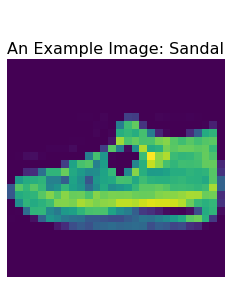

In [14]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

Ok, that looks interesting.  How hard is that for you to recognize? Now let's create the JSON object for a batch of  three inference requests, and see how well our model recognizes things:

In [15]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


### Make REST requests

#### Newest version of the servable

We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples.  We'll ask our server to give us the latest version of our servable by not specifying a particular version.

In [ ]:
# docs_infra: no_execute
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

#### A particular version of the servable

Now let's specify a particular version of our servable.  Since we only have one, let's select version 1.  We'll also look at all three results.

In [ ]:
# docs_infra: no_execute
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))